In [1]:
# =========================================================
# Libraries for Data Manipulation and Visualization
# =========================================================
import numpy as np                               # Numerical operations
import pandas as pd                              # Data manipulation
import matplotlib.pyplot as plt                  # Plotting
import seaborn as sns                            # Advanced data visualization

# =========================================================
# Libraries for Model Building and Evaluation
# =========================================================
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    mean_squared_error, 
    r2_score, 
    mean_absolute_percentage_error, 
    median_absolute_error
)

# =========================================================
# SVR Library
# =========================================================
from sklearn.svm import SVR

# =========================================================
# Set Seed for Reproducibility
# =========================================================
RANDOM_STATE = 50
np.random.seed(RANDOM_STATE)

In [2]:
# Define the path to the dataset
dataset_path = '../../all_data_files/cleaned_dataset_per_device.csv'

# Load the dataset
try:
    df = pd.read_csv(dataset_path)
    print("\nDataset loaded successfully...")
except FileNotFoundError:
    print(f"File not found at the specified path: {dataset_path}")
    import sys
    sys.exit()
    
# Overwrite df with a random 'little' subset of the data
#df = df.sample(frac=0.05, random_state=RANDOM_STATE)

# Display dataset information
print("\nDataset Information:")
df.info()

print("\nFirst Five Rows of the Dataset:")
display(df.head())



Dataset loaded successfully...

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 32816 entries, 313592 to 450814
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         32816 non-null  object 
 1   device_id    32816 non-null  object 
 2   co2          32816 non-null  float64
 3   humidity     32816 non-null  float64
 4   pm25         32816 non-null  float64
 5   pressure     32816 non-null  float64
 6   temperature  32816 non-null  float64
 7   rssi         32816 non-null  float64
 8   snr          32816 non-null  float64
 9   SF           32816 non-null  int64  
 10  frequency    32816 non-null  float64
 11  f_count      32816 non-null  float64
 12  p_count      32816 non-null  float64
 13  toa          32816 non-null  float64
 14  distance     32816 non-null  int64  
 15  c_walls      32816 non-null  int64  
 16  w_walls      32816 non-null  int64  
 17  exp_pl       32816 non-null  floa

,time,device_id,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,distance,c_walls,w_walls,exp_pl,n_power,esp
313592,2025-01-11 13:35:19.856635+00:00,ED2,555.0,32.97,1.55,329.89,21.58,-66.0,11.5,8,868.3,102665.0,113691.0,0.133632,23,0,2,83.4,-77.797062,-66.297062
630637,2024-12-30 21:46:56.370059+00:00,ED5,470.0,40.38,1.92,332.88,15.92,-103.0,4.0,10,868.5,88556.0,96940.0,0.452608,40,2,2,120.4,-108.455405,-104.455405
270588,2024-11-25 21:53:52.441632+00:00,ED2,636.0,36.04,0.47,317.03,24.17,-76.0,7.2,7,868.5,41805.0,46588.0,0.071936,23,0,2,93.4,-83.957462,-76.757462
413399,2025-01-01 18:34:20.159798+00:00,ED3,423.0,32.93,1.55,314.81,19.84,-67.0,9.8,7,867.1,89126.0,99595.0,0.071936,18,1,2,84.4,-77.232494,-67.432494
67181,2024-12-11 14:12:50.857692+00:00,ED0,781.0,35.08,1.30,332.34,21.95,-48.0,12.5,9,868.1,61949.0,69135.0,0.246784,10,0,0,65.4,-60.737602,-48.237602


In [3]:
# Define feature columns and target
feature_columns = [
    'distance', 'frequency', 'c_walls', 'w_walls', 
    'co2', 'humidity', 'pm25', 'pressure', 
    'temperature', 'snr'
]
target_column = 'exp_pl'

# Verify that all required columns exist
missing_columns = set(feature_columns + [target_column]) - set(df.columns)
if missing_columns:
    raise ValueError(f"The following required columns are missing in the dataset: {missing_columns}")

# Extract features and target
all_features = df[feature_columns].values
PL_all = df[target_column].values

# Perform train-test split (80-20 split)
X_train_all, X_test_all, PL_train_all, PL_test_all = train_test_split(
    all_features, PL_all, test_size=0.2, random_state=RANDOM_STATE
)

print("\nTrain-test split completed...\n")


Train-test split completed...



In [4]:
# Define a single set of hyperparameters for SVR
svr_params = {
    'kernel': 'rbf',      # The RBF kernel often works well for non-linear relationships
    'C': 10.0,             # Regularization parameter, higher C => tries to fit more to the data
    'gamma': 'scale',     # Kernel coefficient; 'scale' = 1 / (n_features * X.var())
    'epsilon': 0.1        # Epsilon in the epsilon-SVR model
}

print("\nTraining SVR model with hyperparameters...\n")

# Initialize the SVR model
svr_model = SVR(**svr_params)

# Train the model
svr_model.fit(X_train_all, PL_train_all)

print("Model training completed....!\n")


Training SVR model with hyperparameters...

Model training completed....!



In [5]:
# Initialize a list to store evaluation metrics for the SVR model
evaluation_metrics = []

print("\nEvaluating the trained SVR model...")

# Make predictions on the training set
PL_train_pred = svr_model.predict(X_train_all)

# Make predictions on the test set
PL_test_pred = svr_model.predict(X_test_all)

# Calculate metrics
train_mse = mean_squared_error(PL_train_all, PL_train_pred)
test_mse = mean_squared_error(PL_test_all, PL_test_pred)
train_r2 = r2_score(PL_train_all, PL_train_pred)
test_r2 = r2_score(PL_test_all, PL_test_pred)
test_rmse = np.sqrt(test_mse)
test_mape = mean_absolute_percentage_error(PL_test_all, PL_test_pred)
test_median_ae = median_absolute_error(PL_test_all, PL_test_pred)

# Append metrics to the list
evaluation_metrics.append({
    'Model': 'SVR (RBF)',
    'Training Loss (MSE)': train_mse,
    'Test Loss (MSE)': test_mse,
    'Test RMSE': test_rmse,
    'R² Score': test_r2,
    'Test MAPE (%)': test_mape * 100,
    'Test Median AE': test_median_ae
})

# Convert the metrics list to a DataFrame
evaluation_df = pd.DataFrame(evaluation_metrics)

print(f"\nModel Evaluation Metrics:")
# Display the transposed DataFrame
evaluation_df = evaluation_df.T[1:].reset_index(names=["Metric"]).rename(columns={0: "Value"})
display(evaluation_df)


Evaluating the trained SVR model...

Model Evaluation Metrics:


,Metric,Value
0,Training Loss (MSE),194.264715
1,Test Loss (MSE),186.888125
2,Test RMSE,13.670703
3,R² Score,0.475367
4,Test MAPE (%),11.903253
5,Test Median AE,7.985844


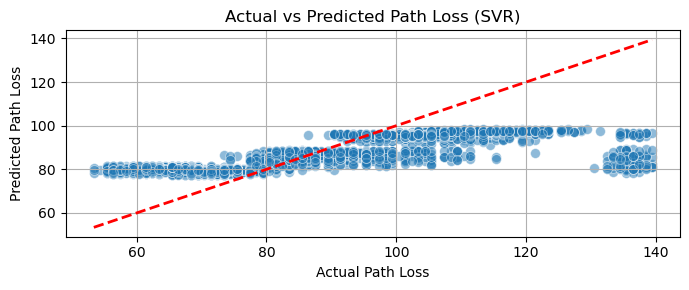

In [6]:
# Plot Actual vs Predicted Path Loss
plt.figure(figsize=(7, 3))
sns.scatterplot(x=PL_test_all, y=PL_test_pred, alpha=0.5, edgecolor='w', s=50)
plt.plot([PL_test_all.min(), PL_test_all.max()], [PL_test_all.min(), PL_test_all.max()], 'r--', lw=2)
plt.xlabel('Actual Path Loss')
plt.ylabel('Predicted Path Loss')
plt.title('Actual vs Predicted Path Loss (SVR)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# Define the number of folds for cross-validation
n_folds = 5

# Initialize KFold with consistent RANDOM_STATE for reproducibility
kf = KFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)

# Initialize a list to store evaluation metrics for each fold
cv_results = []

print("\nPerforming K-Fold Cross-Validation with SVR...\n")

# Iterate over each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_all), 1):
    
    # Split the data for the current fold
    X_train_fold, X_val_fold = X_train_all[train_idx], X_train_all[val_idx]
    PL_train_fold, PL_val_fold = PL_train_all[train_idx], PL_train_all[val_idx]
    
    # Initialize the SVR model with the specified hyperparameters
    svr_model_cv = SVR(**svr_params)
    
    # Train the model on the current fold
    svr_model_cv.fit(X_train_fold, PL_train_fold)
    
    # Make predictions on the validation set
    PL_val_pred = svr_model_cv.predict(X_val_fold)
    
    # Calculate evaluation metrics
    val_mse = mean_squared_error(PL_val_fold, PL_val_pred)
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(PL_val_fold, PL_val_pred)
    val_mape = mean_absolute_percentage_error(PL_val_fold, PL_val_pred)
    val_median_ae = median_absolute_error(PL_val_fold, PL_val_pred)
    
    # Append metrics to the cv_results list
    cv_results.append({
        'Fold': fold,
        'Validation Loss (MSE)': round(val_mse, 4),
        'Validation RMSE': round(val_rmse, 4),
        'R² Score': round(val_r2, 4),
        'Validation MAPE (%)': round(val_mape * 100, 2),
        'Validation Median AE': round(val_median_ae, 4)
    })
    
    # Print metrics for the current fold
    print(f" Fold {fold} - MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}, "
          f"MAPE: {val_mape*100:.2f}%, Median AE: {val_median_ae:.4f}\n")

# Convert the list of dictionaries to a DataFrame for better visualization
cv_results_df = pd.DataFrame(cv_results)

print("K-Fold Cross-Validation Results:")
display(cv_results_df)

# Summary statistics
cv_summary = cv_results_df.agg(['mean', 'std']).round(4).reset_index()
cv_summary.rename(columns={'index': 'Metric'}, inplace=True)

# Transposing the summary
cv_summary_transposed = cv_summary.set_index('Metric').T

print("\nCross-Validation Summary:")
display(cv_summary_transposed)


Performing Manual K-Fold Cross-Validation with SVR...

 Fold 1 - MSE: 212.2979, RMSE: 14.5704, R²: 0.4091, MAPE: 13.13%, Median AE: 8.9832

 Fold 2 - MSE: 218.4336, RMSE: 14.7795, R²: 0.4104, MAPE: 13.40%, Median AE: 9.6228

 Fold 3 - MSE: 219.0501, RMSE: 14.8003, R²: 0.4007, MAPE: 13.10%, Median AE: 9.2582

 Fold 4 - MSE: 218.6334, RMSE: 14.7863, R²: 0.4015, MAPE: 13.19%, Median AE: 9.3913

 Fold 5 - MSE: 206.3462, RMSE: 14.3648, R²: 0.4168, MAPE: 13.09%, Median AE: 9.1767

K-Fold Cross-Validation Results:


,Fold,Validation Loss (MSE),Validation RMSE,R² Score,Validation MAPE (%),Validation Median AE
0,1,212.2979,14.5704,0.4091,13.13,8.9832
1,2,218.4336,14.7795,0.4104,13.40,9.6228
2,3,219.0501,14.8003,0.4007,13.10,9.2582
3,4,218.6334,14.7863,0.4015,13.19,9.3913
4,5,206.3462,14.3648,0.4168,13.09,9.1767



Cross-Validation Summary:


Metric,mean,std
Fold,3.0000,1.5811
Validation Loss (MSE),214.9522,5.5582
Validation RMSE,14.6603,0.1905
R² Score,0.4077,0.0067
Validation MAPE (%),13.1820,0.1279
Validation Median AE,9.2864,0.2392
